# SIS with spatial probability constraints

>**Note** This notebook is ispired by the notebook [ex_geosclassic_indicator_2d.ipynb](https://github.com/randlab/geone/blob/master/examples/ex_geosclassic_indicator_2d.ipynb) by Julien Straubhaar

Very often, the results of some geophysical survey provide a relatively smooth map, that can be for example interpretated as the probability of finding a given facies code at a given location.
Therefore, instead of providing only some global constraints about the target proportions as we illustrated in the previous notebook, one can also include in SIS the probability maps for each facies to be represented.

In this notebook we will demonstrate the usage of SIS when probability maps area available.

As usual, the details that were explained in the previous notebooks are omitted for the sake of brievity.

Fist of all, we ned to install the required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

Define categories and some colors for the plots.

In [2]:
category_values = [1., 2., 3.]
ncategory = len(category_values)
categCol = ['#1b9e77', '#d95f02', '#7570b3'] 
cmap_categ = [gn.customcolors.custom_cmap(['white', c]) for c in categCol]

Same variogram model as the previous example.

In [3]:
cov_model = gn.covModel.CovModel2D(elem=[
    ('exponential', {'w':9., 'r':[150, 40]}), # elementary contribution
    ], alpha=-30, name='model-2D example')

Simulation grid.

In [4]:
nx, ny = 220, 230  # number of cells
dx, dy = 1.0, 1.0  # cell unit
ox, oy = 0.0, 0.0  # origin

dimension = (nx, ny)
spacing = (dx, dy)
origin = (ox, oy)

## Define some probability maps

The probability maps should be defined on the same grid where we want to simulate with SIS.

Here we will use some maps derived from the grid coordinates. In real case studies, the output maps of some geophysical survey can be used.

First of all, we can create a `meshgrid` of the coordinates of our simulation grid. Note that `xg` and `yg` are the coordinates of the grid cell centers.

In [5]:
xg = ox + 0.5*dx + dx*np.arange(nx)
yg = oy + 0.5*dy + dy*np.arange(ny)
xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

An "empty" *Image* object is created to contain the input probability maps. 

In [6]:
im = gn.img.Img(nx, ny, 1, dx, dy, 1., ox, oy, 0., nv=0)

We can create one map (for example, the proportions of facies code `2`, contained in variable `p1`) as the sum of the coordinates $x$ and $y$ on the grid

In [7]:
p1 = xx - yy

If we decide that facies `1` (with probability `p0`) is distributed uniformely in space, for example with a proportion of 10%, then facies `2` (with probability `p1`) and facies `3` (with probability `p2`) will share the remainder 90%.  
We can therefore "normalize" the map for facies `1` accordining to this 90%

In [8]:
# Facies 1 and 2 have the 90% of probability
c = 0.9    
p1 = c * (p1 - np.min(p1))/ (np.max(p1) - np.min(p1))

And compute `p2` and `p0` accordingly

In [9]:
p2 = c - p1
p0 = (1. - c) * np.ones_like(p1) # 1.0 - p1 - p2 # constant map (0.1)

probability = np.array((p0, p1, p2))

The three probability maps should be provided as an *Image* with three variables.

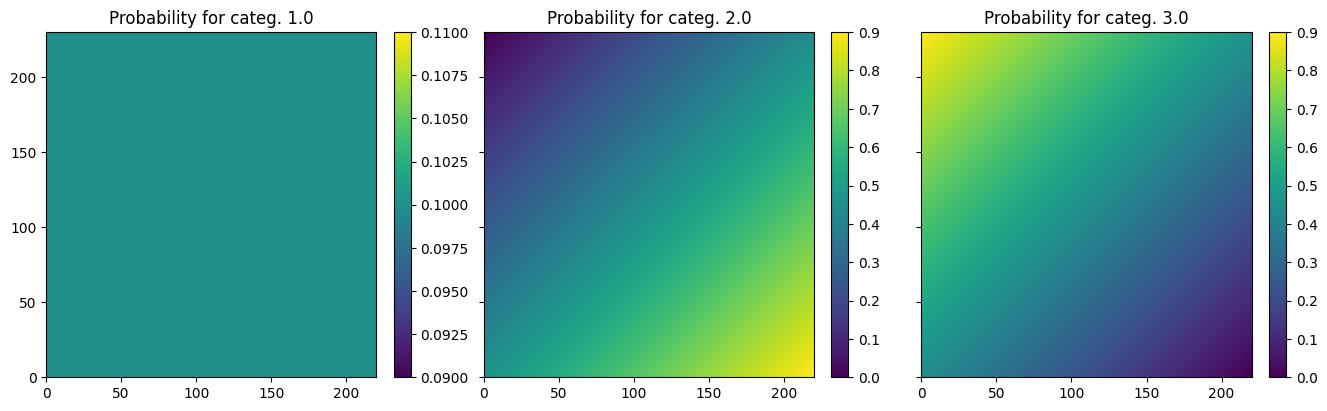

In [10]:
# Set variable p0, p1, p2 in image im
im.append_var(probability, varname=['p0', 'p1', 'p2'])

# Display 
plt.subplots(1, 3, figsize=(16,12), sharey=True)

for i in range(ncategory):
    plt.subplot(1, 3, 1+i)
    gn.imgplot.drawImage2D(im, iv=i, title = 'Probability for categ. {}'.format(category_values[i]))

plt.show()

We also define conditioning data as usual

In [11]:
x = np.array([[ 10.,  20.], # 1st point
              [ 50.,  40.], # 2nd point
              [ 20., 150.], # 3rd point
              [200., 210.]]) # 4th point
v = [ 1., 2., 1., 3.] # values

## Simulation

Here we apply the SIS method with global probability constraints. The main change here is that the argument `probability` is explicitly provided (if this is omitted, facies proportions are computed from the conditioning data, but in this case we only have few).

In [12]:
nreal = 10
np.random.seed(321)

geosclassic_output = gn.geosclassicinterface.simulateIndicator2D(
    category_values, cov_model, dimension, spacing, origin, 
    x=x, v=v, probability=probability, nreal=nreal, nthreads=1)


Geos-Classic running... [VERSION 2.0 / BUILD NUMBER 20230914 / OpenMP 1 thread(s)]
Geos-Classic run complete


## Collect results and plot

In [13]:
# Retrieve the realizations
simul = geosclassic_output['image']

# Compute proportion of each category (pixel-wise)
simul_prop = gn.img.imageCategProp(simul, category_values)

Hereinafter the plots

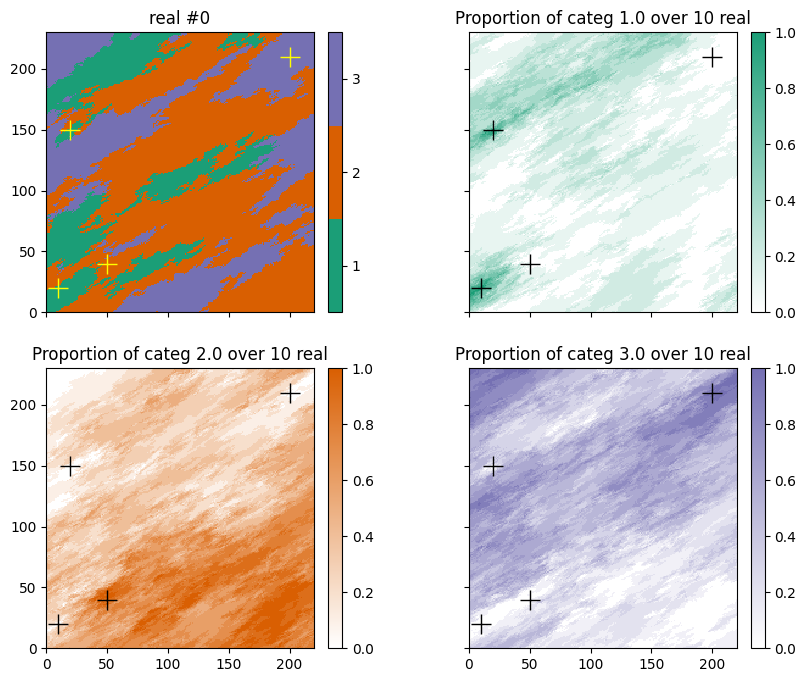

In [16]:
# Plot
plt.subplots(2, 2, figsize=(10,8), sharex=True, sharey=True)

plt.subplot(2,2,1)
gn.imgplot.drawImage2D(simul, iv=2, categ=True, categCol=categCol, title='real #0')
plt.plot(x[:,0],x[:,1], '+', c='yellow', markersize=15) # add conditioning point locations

for i in range(ncategory):
    plt.subplot(2,2,2+i)
    gn.imgplot.drawImage2D(simul_prop, iv=i, vmin=0, vmax=1, cmap=cmap_categ[i], 
                           title='Proportion of categ {0} over {1} real'.format(category_values[i], nreal))
    plt.plot(x[:,0],x[:,1], '+', c='black', markersize=15) # add conditioning point locations